<a href="https://colab.research.google.com/github/ms-shyamkumar/jupyter-notebooks/blob/main/ts_anomaly_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from fbprophet import Prophet

In [ ]:
!wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

In [41]:
FILE_NAME = 'daily-min-temperatures.csv' #csv file with two columns - datetime and value
sensitivity = 1.8  #sensitivity for anaomaly detection, higher means less sensitive
frequency = 'D' #frequency of input data as per prophet

In [56]:
df = pd.read_csv(FILE_NAME)
df.columns = ['ds','y']
df['ds']  = pd.to_datetime(df['ds'], infer_datetime_format=True)
df.drop(df[df['ds']<'1988-01-01'].index, inplace=True)
print(df.shape)
print(df.head(2))

(1095, 2)
             ds     y
2555 1988-01-01  15.3
2556 1988-01-02  14.3


In [57]:
#Create prophet model to reconstruct the timeseries
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1, include_history=True, freq=frequency)
forecast = m.predict(future)
anomaly = pd.merge(df, forecast, on=['ds', 'ds'])
anomaly.head(3)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1988-01-01,15.3,12.157960,11.769136,17.912582,12.157960,12.157960,2.617586,2.617586,2.617586,0.031440,0.031440,0.031440,2.586146,2.586146,2.586146,0.0,0.0,0.0,14.775546
1,1988-01-02,14.3,12.156563,11.659264,17.709391,12.156563,12.156563,2.606475,2.606475,2.606475,-0.103474,-0.103474,-0.103474,2.709949,2.709949,2.709949,0.0,0.0,0.0,14.763038
2,1988-01-03,13.5,12.155165,11.913200,18.095548,12.155165,12.155165,2.743397,2.743397,2.743397,-0.106620,-0.106620,-0.106620,2.850017,2.850017,2.850017,0.0,0.0,0.0,14.898562


In [58]:
#define sensitivity for outliers based on confidence interval and a sensitivity factor

anomaly['upper_margin'] = anomaly['yhat'] + sensitivity*(anomaly['yhat_upper'] - anomaly['yhat'])
anomaly['lower_margin'] = anomaly['yhat'] - sensitivity*(anomaly['yhat'] - anomaly['yhat_lower'])
anomaly['is_anomaly'] = np.where( (anomaly['y']> anomaly['upper_margin']) | (anomaly['y'] < anomaly['lower_margin']), 1, 0)

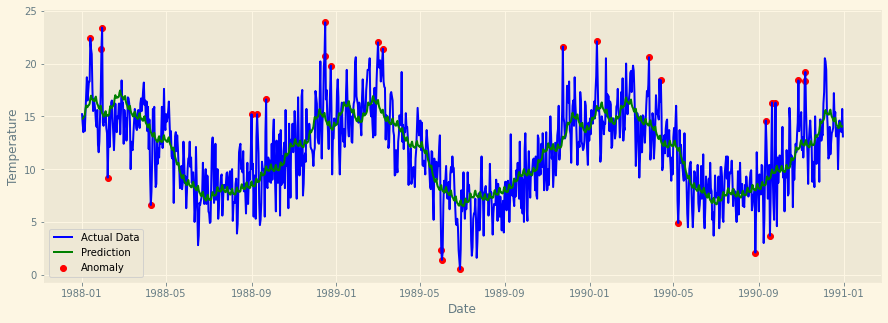

In [65]:
adf = anomaly[anomaly['is_anomaly']==1]
import matplotlib.pyplot as plt

with plt.style.context('Solarize_Light2'):
  fig, ax = plt.subplots(figsize=(15,5))
  ax.plot(anomaly['ds'],anomaly['y'], color='b', label='Actual Data')
  ax.plot(anomaly['ds'], anomaly['yhat'], color='g', label='Prediction')
  ax.scatter(adf['ds'], adf['y'], color='r', label='Anomaly')
  ax.set_xlabel('Date')
  ax.set_ylabel('Temperature')  
  ax.legend();